# View the Spectrum model in prospector

In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import rcParams

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



import re
import h5py
import pandas as pd
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [27]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","violet","blue"])

In [2]:
from astropy import constants as const
from astropy import units as u

In [3]:
import fsps
import sedpy
import prospect

In [4]:
import emcee
import dynesty

In [5]:
from prospect.models.templates import TemplateLibrary

# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'nebular_marginalization':
  Marginalize over emission amplitudes line contained inthe observed spectrum
'fit_eline_redshift':
  Fit for the redshift of the emission lines separatelyfrom the stellar redshift
'agn_eline':
  Add AGN emission lines
'outlier_model':
  The set of outlier (mixture) models for spectroscopy and photometry
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set

In [6]:
TemplateLibrary.describe("parametric_sfh")

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 4 
  imf_type: 2 
  dust_type: 0 


That looks pretty good, this model has 5 free parameters:
- stellar mass *formed* $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- age $t$ of the galaxy 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), and
- dust attenuation optical depth for a foreground screen, $A_V$.


In [7]:
def build_model(object_redshift=None, fixed_metallicity=None, add_duste=False, **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["parametric_sfh"]
    
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = 0.0
    model_params["dust2"]["init"] = 0.05
    model_params["logzsol"]["init"] = -0.5
    model_params["tage"]["init"] = 13.
    model_params["mass"]["init"] = 1e8
    
    # These are dwarf galaxies, so lets also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e10)

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e6
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model




In [8]:
run_params = {}
run_params["object_redshift"] = 0
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

In [9]:
model = build_model(**run_params)

In [10]:
print(model)

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=1000000.0,maxi=10000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=100.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_dust_emission: [ True] 
  duste_umin: [1.] 
  duste_qpah: [4.] 
  duste_gamma: [0.001] 


In [11]:
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))


Initial free parameter vector theta:
  [ 1.0e+08 -5.0e-01  5.0e-02  1.3e+01  1.0e+00]



In [12]:
print("Initial parameter dictionary:\n{}".format(model.params))

Initial parameter dictionary:
{'zred': array([0]), 'mass': array([1.e+08]), 'logzsol': array([-0.5]), 'dust2': array([0.05]), 'sfh': array([4]), 'tage': array([13.]), 'imf_type': array([2]), 'dust_type': array([0]), 'tau': array([1]), 'add_dust_emission': array([ True]), 'duste_umin': array([1.]), 'duste_qpah': array([4.]), 'duste_gamma': array([0.001])}


In [13]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

In [14]:
sps = build_sps(**run_params)
help(sps.get_spectrum)

Help on method get_spectrum in module prospect.sources.ssp_basis:

get_spectrum(outwave=None, filters=None, peraa=False, **params) method of prospect.sources.galaxy_basis.CSPSpecBasis instance
    Get a spectrum and SED for the given params.
    
    :param outwave: (default: None)
        Desired *vacuum* wavelengths.  Defaults to the values in
        ``sps.wavelength``.
    
    :param peraa: (default: False)
        If `True`, return the spectrum in erg/s/cm^2/AA instead of AB
        maggies.
    
    :param filters: (default: None)
        A list of filter objects for which you'd like photometry to be calculated.
    
    :param params:
        Optional keywords giving parameter values that will be used to
        generate the predicted spectrum.
    
    :returns spec:
        Observed frame spectrum in AB maggies, unless ``peraa=True`` in which
        case the units are erg/s/cm^2/AA.
    
    :returns phot:
        Observed frame photometry in AB maggies.
    
    :returns ma

In [15]:
run_params

{'object_redshift': 0,
 'fixed_metallicity': None,
 'add_duste': True,
 'zcontinuous': 1}

In [16]:
model_params = {}
model_params["zred"] = 0.0
model_params["dust2"] = 0.0
model_params["logzsol"] = -0.5
model_params["tage"] = 13.
model_params["mass"] = 1e8

In [17]:
N = 10
dust = np.linspace(0,2,N)
color = cm.rainbow(np.linspace(0, 1, N))

In [19]:
list_of_modelparams = []
list_wl = []
list_spec = []
for idx in range(N):
    new_model_params  = model_params 
    new_model_params["dust2"] = dust[idx]
    spectr, photom, mass_frac = sps.get_spectrum(outwave=None, filters=None, peraa=True,**new_model_params)
    wspec = sps.wavelengths
    list_wl.append(wspec)
    list_spec.append(spectr)
    list_of_modelparams.append(new_model_params)

Text(0.5, 1.0, 'impact of dust')

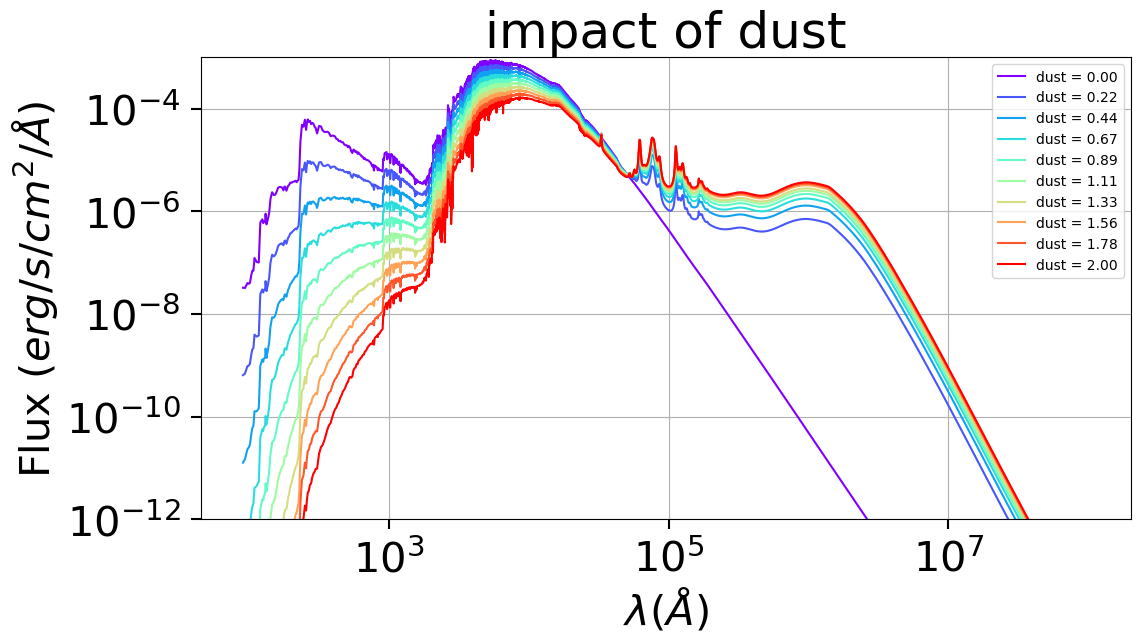

In [31]:
fig = plt.figure(figsize = (12,6))
ax=fig.add_subplot(1,1,1)
for idx in range(N):
    val = dust[idx]
    label = f"dust = {val:.2f}"
    ax.loglog(wspec,list_spec[idx],color=color[idx],label=label)

ax.grid()
ax.set_ylim(1e-12,1e-3)
ax.legend(fontsize=10)
ax.set_xlabel("$\lambda (\AA)$")
ax.set_ylabel("Flux $(erg/s/cm^2/\AA)$")
ax.set_title("impact of dust")

Text(0.5, 1.0, 'impact of dust')

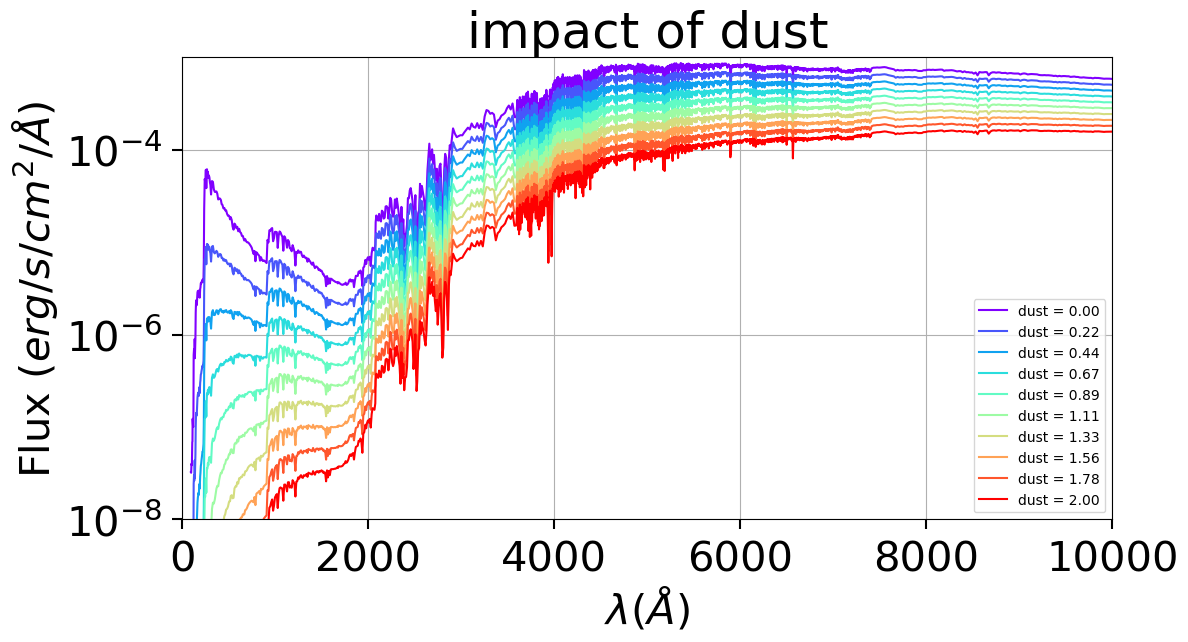

In [32]:
fig = plt.figure(figsize = (12,6))
ax=fig.add_subplot(1,1,1)
for idx in range(N):
    val = dust[idx]
    label = f"dust = {val:.2f}"
    ax.semilogy(wspec,list_spec[idx],color=color[idx],label=label)

ax.grid()
ax.set_ylim(1e-8,1e-3)
ax.set_xlim(0,10000)
ax.legend(fontsize=10)
ax.set_xlabel("$\lambda (\AA)$")
ax.set_ylabel("Flux $(erg/s/cm^2/\AA)$")
ax.set_title("impact of dust")

In [33]:
list_of_modelparams = []
list_wl = []
list_spec = []
for idx in range(N):
    new_model_params  = model_params 
    new_model_params["dust2"] = dust[idx]
    spectr, photom, mass_frac = sps.get_spectrum(outwave=None, filters=None, peraa=False,**new_model_params)
    wspec = sps.wavelengths
    list_wl.append(wspec)
    list_spec.append(spectr)
    list_of_modelparams.append(new_model_params)

Text(0.5, 1.0, 'impact of dust')

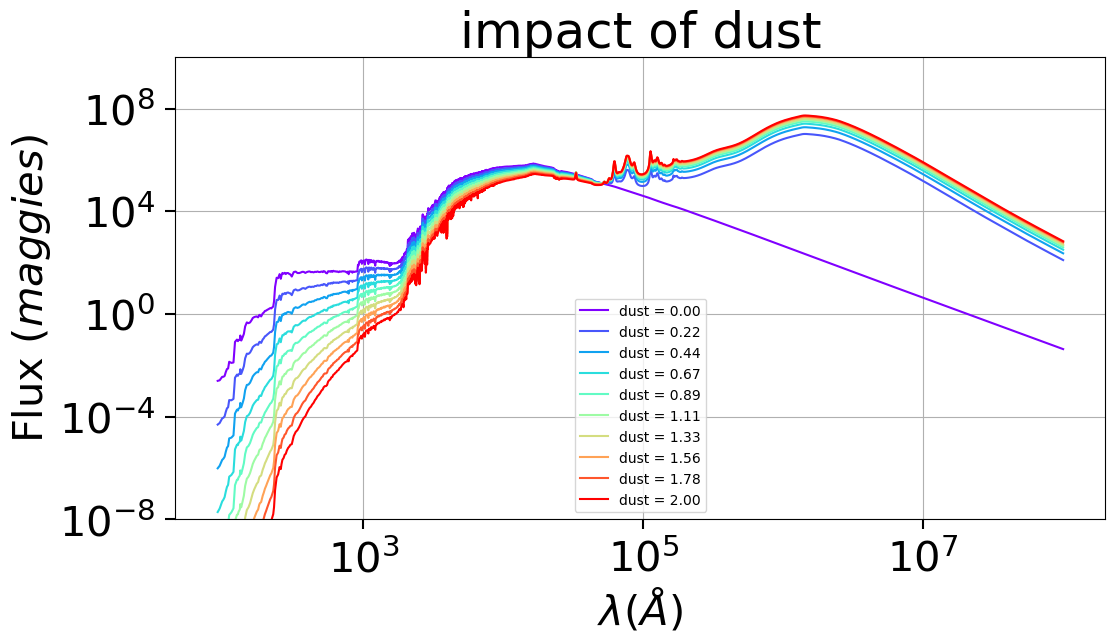

In [38]:
fig = plt.figure(figsize = (12,6))
ax=fig.add_subplot(1,1,1)
for idx in range(N):
    val = dust[idx]
    label = f"dust = {val:.2f}"
    ax.loglog(wspec,list_spec[idx],color=color[idx],label=label)

ax.grid()
ax.set_ylim(1e-8,1e10)
ax.legend(fontsize=10)
ax.set_xlabel("$\lambda (\AA)$")
ax.set_ylabel("Flux $(maggies)$")
ax.set_title("impact of dust")

Text(0.5, 1.0, 'impact of dust')

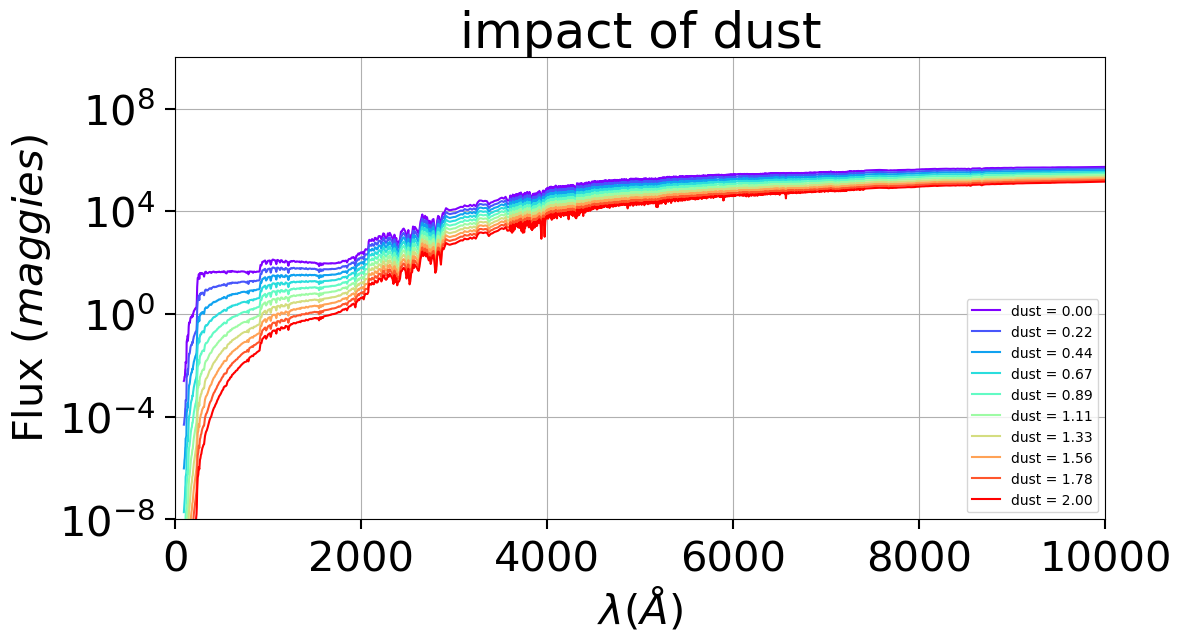

In [40]:
fig = plt.figure(figsize = (12,6))
ax=fig.add_subplot(1,1,1)
for idx in range(N):
    val = dust[idx]
    label = f"dust = {val:.2f}"
    ax.semilogy(wspec,list_spec[idx],color=color[idx],label=label)

ax.grid()
ax.set_ylim(1e-8,1e10)
ax.set_xlim(0,10000)
ax.legend(fontsize=10)
ax.set_xlabel("$\lambda (\AA)$")
ax.set_ylabel("Flux $(maggies)$")
ax.set_title("impact of dust")